# NLP 2 : Neural Embeddings, Text Classification, Text Generation


To use statistical classifiers with text, it is first necessary to vectorize the text. In the first practical session we explored the **bag of word** model. 

Modern **state of the art** methods uses  embeddings to vectorize the text before classification in order to avoid feature engineering.

## Dataset
https://github.com/cedias/practicalNLP/tree/master/dataset

## "Modern" NLP pipeline

By opposition to the **bag of word** model, in the modern NLP pipeline everything is **embeddings**. Instead of encoding a text as a **sparse vector** of length $D$ (size of feature dictionnary) the goal is to encode the text in a meaningful dense vector of a small size $|e| <<< |D|$. 


The raw classification pipeline is then the following:

```
raw text ---|embedding table|-->  vectors --|Neural Net|--> class 
```


### Using a  language model:

How to tokenize the text and extract a feature dictionnary is still a manual task. To directly have meaningful embeddings, it is common to use a pre-trained language model such as `word2vec` which we explore in this practical.

In this setting, the pipeline becomes the following:
```
      
raw text ---|(pre-trained) Language Model|--> vectors --|classifier (or fine-tuning)|--> class 
```


- #### Classic word embeddings

 - [Word2Vec](https://arxiv.org/abs/1301.3781)
 - [Glove](https://nlp.stanford.edu/projects/glove/)


- #### bleeding edge language models techniques (only here for reference)

 - [UMLFIT](https://arxiv.org/abs/1801.06146)
 - [ELMO](https://arxiv.org/abs/1802.05365)
 - [GPT](https://blog.openai.com/language-unsupervised/)
 - [BERT](https://arxiv.org/abs/1810.04805)






### Goal of this session:

1. Train word embeddings on training dataset
2. Tinker with the learnt embeddings and see learnt relations
3. Tinker with pre-trained embeddings.
4. Use those embeddings for classification
5. Compare different embedding models
6. Pytorch first look: learn to generate text.





##  Loading data (same as in nlp 1)

In [1]:
import json
from collections import Counter

#### /!\ YOU NEED TO UNZIP dataset/json_pol.zip first /!\


# Loading json
with open("dataset/json_pol",encoding="utf-8") as f:
    data = f.readlines()
    json_data = json.loads(data[0])
    train = json_data["train"]
    test = json_data["test"]
    

# Quick Check
counter_train = Counter((x[1] for x in train))
counter_test = Counter((x[1] for x in test))
print("Number of train reviews : ", len(train))
print("----> # of positive : ", counter_train[1])
print("----> # of negative : ", counter_train[0])
print("")
print(train[0])
print("")
print("Number of test reviews : ",len(test))
print("----> # of positive : ", counter_test[1])
print("----> # of negative : ", counter_test[0])

print("")
print(test[0])
print("")



Number of train reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

["The undoubted highlight of this movie is Peter O'Toole's performance. In turn wildly comical and terribly terribly tragic. Does anybody do it better than O'Toole? I don't think so. What a great face that man has!<br /><br />The story is an odd one and quite disturbing and emotionally intense in parts (especially toward the end) but it is also oddly touching and does succeed on many levels. However, I felt the film basically revolved around Peter O'Toole's luminous performance and I'm sure I wouldn't have enjoyed it even half as much if he hadn't been in it.", 1]

Number of test reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

['Although credit should have been given to Dr. Seuess for stealing the story-line of "Horton Hatches The Egg", this was a fine film. It touched both the emotions and the intellect. Due especially to the incredible performance of seven year old 

## Word2Vec: Quick Recap

**[Word2Vec](https://arxiv.org/abs/1301.3781) is composed of two distinct language models (CBOW and SG), optimized to quickly learn word vectors**


given a random text: `i'm taking the dog out for a walk`



### (a) Continuous Bag of Word (CBOW)
    -  predicts a word given a context
    
maximizing `p(dog | i'm taking the ___ out for a walk)`
    
### (b) Skip-Gram (SG)               
    -  predicts a context given a word
    
 maximizing `p(i'm taking the out for a walk | dog)`



   

## Step 1: train (or load) a language model (word2vec)

Gensim has one of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) fastest implementation.


### Train:

In [2]:
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

text = [t.lower().split() for t,p in train]

# the following configuration is the default configuration
w2v = gensim.models.word2vec.Word2Vec(sentences=text,
                                size=100, window=5,               ### here we train a cbow model 
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=0, hs=0, negative=5,        ### set sg to 1 to train a sg model
                                cbow_mean=1,
                                iter=5)

2021-05-22 12:27:23,900 : INFO : collecting all words and their counts
2021-05-22 12:27:23,901 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-05-22 12:27:24,482 : INFO : PROGRESS: at sentence #10000, processed 2358544 words, keeping 140969 word types
2021-05-22 12:27:25,069 : INFO : PROGRESS: at sentence #20000, processed 4675912 words, keeping 218529 word types
2021-05-22 12:27:25,364 : INFO : collected 251637 word types from a corpus of 5844680 raw words and 25000 sentences
2021-05-22 12:27:25,365 : INFO : Loading a fresh vocabulary
2021-05-22 12:27:25,843 : INFO : effective_min_count=5 retains 46157 unique words (18% of original 251637, drops 205480)
2021-05-22 12:27:25,844 : INFO : effective_min_count=5 leaves 5552884 word corpus (95% of original 5844680, drops 291796)
2021-05-22 12:27:26,026 : INFO : deleting the raw counts dictionary of 251637 items
2021-05-22 12:27:26,032 : INFO : sample=0.001 downsamples 45 most-common words
2021-05-22 12:27:26,

In [9]:
#most similar
print(w2v.wv.most_similar(['blood'], topn=5))

[('blood,', 0.7728791236877441), ('violence', 0.6947540044784546), ('gore,', 0.6719174385070801), ('nudity', 0.6580226421356201), ('gratuitous', 0.6537489891052246)]


In [15]:
#CBOW
print(w2v.predict_output_word(['gun'],topn=5))

[('gun', 0.008440515), ('machine', 0.002059182), ('opens', 0.001786327), ('shoots', 0.0017689086), ('fight', 0.0016783742)]


In [6]:
w2v_sg = gensim.models.word2vec.Word2Vec(sentences=text,
                                size=100, window=5,               ### here we train a cbow model 
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=1, hs=0, negative=5,        ### set sg to 1 to train a sg model
                                cbow_mean=1,
                                iter=5)

2021-05-01 23:37:18,591 : INFO : collecting all words and their counts
2021-05-01 23:37:18,592 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-05-01 23:37:19,033 : INFO : PROGRESS: at sentence #10000, processed 2358544 words, keeping 140969 word types
2021-05-01 23:37:19,493 : INFO : PROGRESS: at sentence #20000, processed 4675912 words, keeping 218529 word types
2021-05-01 23:37:19,749 : INFO : collected 251637 word types from a corpus of 5844680 raw words and 25000 sentences
2021-05-01 23:37:19,750 : INFO : Loading a fresh vocabulary
2021-05-01 23:37:20,052 : INFO : effective_min_count=5 retains 46157 unique words (18% of original 251637, drops 205480)
2021-05-01 23:37:20,053 : INFO : effective_min_count=5 leaves 5552884 word corpus (95% of original 5844680, drops 291796)
2021-05-01 23:37:20,211 : INFO : deleting the raw counts dictionary of 251637 items
2021-05-01 23:37:20,217 : INFO : sample=0.001 downsamples 45 most-common words
2021-05-01 23:37:20,

2021-05-01 23:38:22,373 : INFO : EPOCH 4 - PROGRESS: at 91.18% examples, 316817 words/s, in_qsize 5, out_qsize 0
2021-05-01 23:38:23,383 : INFO : EPOCH 4 - PROGRESS: at 98.91% examples, 316904 words/s, in_qsize 5, out_qsize 0
2021-05-01 23:38:23,501 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-05-01 23:38:23,521 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-05-01 23:38:23,527 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-05-01 23:38:23,528 : INFO : EPOCH - 4 : training on 5844680 raw words (4213905 effective words) took 13.3s, 316883 effective words/s
2021-05-01 23:38:24,556 : INFO : EPOCH 5 - PROGRESS: at 6.94% examples, 295525 words/s, in_qsize 5, out_qsize 0
2021-05-01 23:38:25,572 : INFO : EPOCH 5 - PROGRESS: at 14.72% examples, 307530 words/s, in_qsize 5, out_qsize 0
2021-05-01 23:38:26,572 : INFO : EPOCH 5 - PROGRESS: at 22.28% examples, 310381 words/s, in_qsize 5, out_qsize 0
2021-05-01 23:38:27,593 :

In [11]:
#most similar
print(w2v_sg.wv.most_similar(['blood'], topn=5))

[('blood,', 0.7791843414306641), ('gore', 0.7405943870544434), ('bloody', 0.7211947441101074), ('blood.', 0.6931116580963135), ('buckets', 0.6863688230514526)]


In [16]:
#SG
print(w2v_sg.predict_output_word(['gun'],topn=5))

[('gun', 0.005693438), ('machine', 0.0013765082), ('shoots', 0.00090895087), ('arm', 0.00081521034), ('guns', 0.0006648248)]


### Load pre-trained embeddings:

In [31]:
# It's for later
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
wv_from_text = KeyedVectors.load_word2vec_format(datapath('word2vec_pre_kv_c'), binary=False)  # C text format

2021-05-02 00:21:39,727 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-05-02 00:21:39,729 : INFO : built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)
2021-05-02 00:21:39,730 : INFO : loading projection weights from C:\Users\William\Anaconda3\lib\site-packages\gensim\test\test_data\word2vec_pre_kv_c
2021-05-02 00:21:39,775 : INFO : loaded (1750, 10) matrix from C:\Users\William\Anaconda3\lib\site-packages\gensim\test\test_data\word2vec_pre_kv_c


In Gensim, embeddings are loaded and can be used via the ["KeyedVectors"](https://radimrehurek.com/gensim/models/keyedvectors.html) class

> Since trained word vectors are independent from the way they were trained (Word2Vec, FastText, WordRank, VarEmbed etc), they can be represented by a standalone structure, as implemented in this module.

>The structure is called “KeyedVectors” and is essentially a mapping between entities and vectors. Each entity is identified by its string id, so this is a mapping between {str => 1D numpy array}.

>The entity typically corresponds to a word (so the mapping maps words to 1D vectors), but for some models, they key can also correspond to a document, a graph node etc. To generalize over different use-cases, this module calls the keys entities. Each entity is always represented by its string id, no matter whether the entity is a word, a document or a graph node.

## STEP 2: Test learnt embeddings

The word embedding space directly encodes similarities between words: the vector coding for the word "great" will be closer to the vector coding for "good" than to the one coding for "bad". Generally, [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is the distance used when considering distance between vectors.

KeyedVectors have a built in [similarity](https://radimrehurek.com/gensim/models /keyedvectors.html#gensim.models.keyedvectors.BaseKeyedVectors.similarity) method to compute the cosine similarity between words

In [17]:
# is great really closer to good than to bad ?
print("Modèle CBOW : great and good:",w2v.wv.similarity("great","good"))
print("Modèle CBOW : great and bad:",w2v.wv.similarity("great","bad"))
print("Modèle SG : great and good:",w2v_sg.wv.similarity("great","good"))
print("Modèle SG : great and bad:",w2v_sg.wv.similarity("great","bad"))

Modèle CBOW : great and good: 0.7663591
Modèle CBOW : great and bad: 0.5138367
Modèle SG : great and good: 0.7585448
Modèle SG : great and bad: 0.47639462


Since cosine distance encodes similarity, neighboring words are supposed to be similar. The [most_similar](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.BaseKeyedVectors.most_similar) method returns the `topn` words given a query.

In [22]:
# The query can be as simple as a word, such as "movie"

# Try changing the word
#print(w2v.wv.most_similar("movie",topn=5)) # 5 most similar words
# print(w2v.wv.most_similar("awesome",topn=5))
print(w2v.wv.most_similar("computer",topn=5))
# print(w2v_sg.wv.most_similar("movie",topn=5)) # 5 most similar words
# print(w2v_sg.wv.most_similar("awesome",topn=5))
# print(w2v_sg.wv.most_similar("actor",topn=5))

[('digital', 0.6952984929084778), ('technology', 0.6548064947128296), ('make-up', 0.6426851749420166), ('cg', 0.6425226926803589), ('camera,', 0.6424719095230103)]


But it can be a more complicated query
Word embedding spaces tend to encode much more.

The most famous exemple is: `vec(king) - vec(man) + vec(woman) => vec(queen)`

In [58]:
# What is awesome - good + bad ?
#print(w2v.wv.most_similar(positive=["awesome","bad"],negative=["good"],topn=3))

#print(w2v.wv.most_similar(positive=["man","woman"],negative=["king"],topn=5)) # do the famous exemple works for actor ?
#print(w2v.wv.most_similar(positive=["data","student","science"],negative=["code"],topn=3))
# Try other things like plurals for exemple.
#print(w2v.wv.most_similar(positive=["women","men"],negative=["man"],topn=3))

print(w2v.wv.most_similar(positive=["data","student"],negative=["code"],topn=3))

[('gardener', 0.7268567681312561), ('dealer', 0.7106071710586548), ('nerdy', 0.7070906162261963)]


In [25]:
# What is awesome - good + bad ?
#print(w2v.wv.most_similar(positive=["awesome","bad"],negative=["good"],topn=3))

#print(w2v.wv.most_similar(positive=["man","woman"],negative=["king"],topn=5)) # do the famous exemple works for actor ?
print(w2v.wv.most_similar(positive=["data","student"],negative=["code"],topn=3))
#print(w2v.wv.most_similar(positive=["data","student","science"],negative=["code"],topn=3))
# Try other things like plurals for exemple.
print(w2v.wv.most_similar(positive=["beds","books"],negative=["sleep"],topn=3))

[('pianist', 0.7420253157615662), ('mechanic', 0.7139220833778381), ('adores', 0.7137610912322998)]
[('novels', 0.7172544002532959), ('adaptations', 0.6937443017959595), ('bloch', 0.6852920055389404)]


To test learnt "synctactic" and "semantic" similarities, Mikolov et al. introduced a special dataset containing a wide variety of three way similarities.

In [59]:
out = w2v.wv.accuracy("dataset/questions-words.txt",case_insensitive=True)  #original semantic syntactic dataset.

C:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `accuracy` (Method will be removed in 4.0.0, use self.evaluate_word_analogies() instead).
  """Entry point for launching an IPython kernel.
2021-04-29 17:37:30,480 : INFO : capital-common-countries: 3.6% (2/56)
2021-04-29 17:37:30,571 : INFO : capital-world: 3.7% (1/27)
2021-04-29 17:37:30,631 : INFO : currency: 0.0% (0/18)
2021-04-29 17:37:31,379 : INFO : city-in-state: 0.4% (1/249)
2021-04-29 17:37:32,398 : INFO : family: 36.5% (125/342)
2021-04-29 17:37:35,387 : INFO : gram1-adjective-to-adverb: 0.8% (7/870)
2021-04-29 17:37:36,771 : INFO : gram2-opposite: 2.4% (11/462)
2021-04-29 17:37:39,912 : INFO : gram3-comparative: 22.8% (241/1056)
2021-04-29 17:37:41,598 : INFO : gram4-superlative: 11.1% (61/552)
2021-04-29 17:37:43,867 : INFO : gram5-present-participle: 16.1% (122/756)
2021-04-29 17:37:46,036 : INFO : gram6-nationality-adjective: 0.9% (7/737)
2021-04-29 17:37:49,647 :

When training the w2v models on the review dataset, since it hasn't been learnt with a lot of data, it does not perform very well. 


## STEP 3:  sentiment classification

In the previous practical session, we used a bag of word approach to transform text into vectors.
Here, we propose to try to use word vectors (previously learnt or loaded).


### <font color='green'> Since we have only word vectors and that sentences are made of multiple words, we need to aggregate them. </font>


### (1) Vectorize reviews using word vectors:

Word aggregation can be done in different ways:

- Sum
- Average
- Min/feature
- Max/feature

#### a few pointers:

- `w2v.wv.vocab` is a `set()` of the vocabulary (all existing words in your model)
- `np.minimum(a,b) and np.maximum(a,b)` respectively return element-wise min/max 

In [28]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# We first need to vectorize text:
# First we propose to a sum of them

def vectorize(text, model, mean=False):
    """
    This function should vectorize one review
    """
    text = text.split()
    vec = np.zeros(model.vector_size)
    cpt = 0
    for word in text:
        if word in model.vocab:
            vec += model.get_vector(word)
            cpt += 1
    if (mean == True) and (cpt != 0):
        vec /= cpt

    return vec

# classes = [pol for text,pol in train]
# X = [vectorize(text) for text,pol in train]
# X_test = [vectorize(text) for text,pol in test]
# true = [pol for text,pol in test]

def evalutation(models, models_name):
    res = []
    logreg = LogisticRegression(random_state=0)
    classes = [pol for text,pol in train]
    true = [pol for text,pol in test]
    for mi in range(len(models)):
        X = [vectorize(text, models[mi]) for text,pol in train]
        X_test = [vectorize(text, models[mi]) for text,pol in test]
        logreg.fit(X,classes)
        ypred = logreg.predict(X_test)
        res.append({'Model':models_name[mi],'Aggregation':'sum','Score':accuracy_score(true, ypred)})
        
        X_mean = [vectorize(text, models[mi], True) for text,pol in train]
        X_test_mean = [vectorize(text, models[mi], True) for text,pol in test]
        logreg.fit(X_mean,classes)
        ypred = logreg.predict(X_test_mean)
        accuracy_score(true, ypred)
        res.append({'Model':models_name[mi],'Aggregation':'mean','Score':accuracy_score(true, ypred)})
        
    return res 
#let's see what a review vector looks like.
#print(X[0])

### (2) Train a classifier 
as in the previous practical session, train a logistic regression to do sentiment classification with word vectors



In [27]:
print(w2v.wv.vector_size)

100


In [32]:
%%time
import pandas as pd
# Scikit Logistic Regression
# logreg = LogisticRegression()
# logreg.fit(X,classes)
# ypred = logreg.predict(X_test)

# print(accuracy_score(true, ypred))

models = [wv_from_text, w2v.wv, w2v_sg.wv]
names = ["w2v_pretrained","w2v_cbow", "w2v_sg"]
eval = evalutation(models, names)
pd.DataFrame(eval).sort_values(by='Score', ascending=False)

C:\Users\William\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\William\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

Wall time: 3min 8s


,Model,Aggregation,Score
4,w2v_sg,sum,0.82160
5,w2v_sg,mean,0.82108
3,w2v_cbow,mean,0.77892
2,w2v_cbow,sum,0.77764
0,w2v_pretrained,sum,0.58000
1,w2v_pretrained,mean,0.56612


performance should be worst than with bag of word (~80%). Sum/Mean aggregation does not work well on long reviews (especially with many frequent words). This adds a lot of noise.

## **Todo** :  Try answering the following questions:

- Which word2vec model works best: skip-gram or cbow
- Do pretrained vectors work best than those learnt on the train dataset ?



**(Bonus)** To have a better accuracy, we could try two things:
- Better aggregation methods (weight by tf-idf ?)
- Another word vectorizing method such as [fasttext](https://radimrehurek.com/gensim/models/fasttext.html)
- A document vectorizing method such as [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html)

## --- Generate text with a recurrent neural network (Pytorch) ---
### (Mostly Read & Run)

The goal is to replicate the (famous) experiment from [Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

To learn to generate text, we train a recurrent neural network to do the following task:

Given a "chunk" of text: `this is random text`

the goal of the network is to predict each character in **`his is random text` ** sequentially given the following sequential input **`this is random tex`**:




## Load text (dataset/input.txt)

Before building training batch, we load the full text in RAM

In [2]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('dataset/input.txt').read()) #clean text => only ascii
file_len = len(file)
print('file_len =', file_len)


file_len = 1115394


## 2: Helper functions:

We have a text and we want to feed batch of chunks to a neural network:

one chunk  A,B,C,D,E
[input] A,B,C,D -> B,C,D,E [output]

Note: we will use an embedding layer instead of a one-hot encoding scheme.

for this, we have 3 functions:

- One to get a random str chunk of size `chunk_len` : `random_chunk` 
- One to turn a chunk into a tensor of size `(1,chunk_len)` coding for each characters : `char_tensor`
- One to return random input and output chunks of size `(batch_size,chunk_len)` : `random_training_set`




In [82]:
import time, math


#Get a piece of text
def random_chunk(chunk_len):
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]


# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(1,len(string)).long()
    for c in range(len(string)):
        tensor[0,c] = all_characters.index(string[c])
    return tensor


#Turn a piece of text in train/test
def random_training_set(chunk_len=200, batch_size=8):
    chunks = [random_chunk(chunk_len) for _ in range(batch_size)]
    inp = torch.cat([char_tensor(chunk[:-1]) for chunk in chunks],dim=0)
    target = torch.cat([char_tensor(chunk[1:]) for chunk in chunks],dim=0)
    
    return inp, target

print(random_training_set(10,4))  ## should return 8 chunks of 10 letters. 

(tensor([[28, 29, 94, 48, 30, 28, 18, 12, 18, 10],
        [24, 27, 13, 73, 94, 32, 18, 29, 17, 94],
        [11, 21, 14, 94, 15, 24, 27, 94, 10, 94],
        [96, 46, 44, 49, 42, 94, 40, 39, 58, 36]]), tensor([[29, 94, 48, 30, 28, 18, 12, 18, 10, 23],
        [27, 13, 73, 94, 32, 18, 29, 17, 94, 10],
        [21, 14, 94, 15, 24, 27, 94, 10, 94, 23],
        [46, 44, 49, 42, 94, 40, 39, 58, 36, 53]]))


## The actual RNN model (only thing to complete):

It should be composed of three distinct modules:

- an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) (n_characters, hidden_size)

```
nn.Embedding(len_dic,size_vec)
```
- a [recurrent](https://pytorch.org/docs/stable/nn.html#recurrent-layers) layer (hidden_size, hidden_size)
```
nn.RNN(in_size,out_size) or nn.GRU() or nn.LSTM() => rnn_cell parameter
```
- a [prediction](https://pytorch.org/docs/stable/nn.html#linear) layer (hidden_size, output_size)

```
nn.Linear(in_size,out_size)
```
=> Complete the `init` function code

In [86]:
import torch.nn.functional as f

class RNN(nn.Module):
    
    def __init__(self, n_char, hidden_size, output_size, n_layers=1,rnn_cell=nn.RNN):
        """
        Create the network
        """
        super(RNN, self).__init__()
        
        self.n_char = n_char
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        #  (batch,chunk_len) -> (batch, chunk_len, hidden_size)  
        self.embed = nn.Embedding(n_char, hidden_size)
        
        # (batch, chunk_len, hidden_size)  -> (batch, chunk_len, hidden_size)  
        self.rnn = rnn_cell(hidden_size, hidden_size)
        
        #(batch, chunk_len, hidden_size) -> (batch, chunk_len, output_size)  
        self.predict = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        """
        batched forward: input is (batch > 1,chunk_len)
        """
        input = self.embed(input)
        output,_  = self.rnn(input)
        output = self.predict(f.tanh(output))
        return output
    
    def forward_seq(self, input,hidden=None):
        """
        not batched forward: input is  (1,chunk_len)
        """
        input = self.embed(input)
        output,hidden  = self.rnn(input.unsqueeze(0),hidden)
        output = self.predict(f.tanh(output))
        return output,hidden

## Text generation function

Sample text from the model

In [85]:
def generate(model,prime_str='A', predict_len=100, temperature=0.8):
    prime_input = char_tensor(prime_str).squeeze(0)
    hidden = None
    predicted = prime_str+""
    # Use priming string to "build up" hidden state

    for p in range(len(prime_str)-1):
        _,hidden = model.forward_seq(prime_input[p].unsqueeze(0),hidden)
            
    #print(hidden.size())
    for p in range(predict_len):
        output, hidden = model.forward_seq(prime_input[-1].unsqueeze(0), hidden)
                # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        #print(output_dist)
        top_i = torch.multinomial(output_dist, 1)[0]
        #print(top_i)
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        prime_input = torch.cat([prime_input,char_tensor(predicted_char).squeeze(0)])

    return predicted

## Training loop for net

**RNN**

In [92]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

###Parameters
n_epochs = 10000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 5
lr = 0.005
batch_size = 16
chunk_len = 80

####

model = RNN(n_characters, hidden_size, n_characters, n_layers) #create model
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses = []
loss_avg = 0


def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer.zero_grad() 
    
    # predict output
    output = model(inp)
    
    #compute loss
    loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1)) 

    #compute gradients and backpropagate
    loss.backward() 
    model_optimizer.step() 

    return loss.data.item() 



for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len,batch_size))  #train on one chunk 
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')
       


    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


 2s (100 1%) 2.5696]
Whees blala; CARIf th lin
I tanithare phiofanetinonechend I my cainch, g tlllew the athathater the y h 

 5s (200 2%) 2.5100]
Whiandeis te f ur:
I:
Wat in or G ngathr me's f man thes p, s inerounof KENowe thar y, must my at o q  

 8s (300 3%) 2.5400]
Wher e f IULAnghis.

; hare, t thinerellelir'd iey lder head whe thapor pouthesssthourir de r t s s br 

 11s (400 4%) 2.4492]
Whid d.
Istowit ingh
Anow' I I s:
Tour be f ntithau LI a wond met dowe t te bin.

S:
Thea t seanas ito 

 14s (500 5%) 2.5106]
Where sy s Cid in: ay, my the thienkengel sethake e: s Gre we atasof se dousuy whewe tor melly mor t a 

 16s (600 6%) 2.5494]
Whoucoroo beay f inthenor r me:
Thes, a s fom fanin.
POns th.
Whence, hesUCowent t sare l s t, heato i 

 19s (700 7%) 2.4543]
Whcelt s h fin t o r frethalarel CAngowinde ls Hands Loup'done t thain m sse?
Myol d tar y t nt y ent  

 22s (800 8%) 2.5016]
Wham onge o thasheat ch pe heatelicatistherifou the mun.
Have I t s mofele wen and charanghe

 51s (6400 64%) 2.5111]
Whe usortacr bed, t wiminthowe; h he onort ter ar the wfe go ke o, cowe t, wase, t ge je the, fou st l 

 53s (6500 65%) 2.4663]
Whe mur and s, hathe chainggane twieristhawere it.

Whe a the hieyo s he ghee tirenorverear th, fousou 

 56s (6600 66%) 2.4231]
Whou ay IS: ppen hal bu t d
He he hes be lllot the I Ang wnd mere t sapll be are us bll d he ckeasthe  

 59s (6700 67%) 2.4848]
Wheathinsomelonss the pthund heanolas pre ll co s lenig ar t n! hel yond:
Ishofith CAn thosaprd be ry  

 2s (6800 68%) 2.4889]
Whe eangr te wistilll the athens men ou s.

If I orenitht and gr han ay, fou by t, mand y the yote wen 

 4s (6900 69%) 2.5242]
Whenghing toriru tifond y I forisen biticowiry e brt abrt has pe west, m inguris oul t witige, ce I an 

 7s (7000 70%) 2.5193]
Whe, ou awhee ders.
I Busthere
K:


Nur'dre pe ped ckisare theldo the Cins t ighanghenshendse t lun st 

 10s (7100 71%) 2.4794]
Whan s str areris s, yo ponds metouthereastour whad tha wereeckelle thages:


**GRU**

In [93]:
###Parameters
n_epochs = 10000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 5
lr = 0.005
batch_size = 16
chunk_len = 80

model2 = RNN(n_characters, hidden_size, n_characters, n_layers, nn.GRU) #create model
model_optimizer2 = torch.optim.Adam(model2.parameters(), lr=lr) #create Adam optimizer

criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses2 = []
loss_avg = 0


def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer2.zero_grad() 
    
    # predict output
    output = model2(inp)
    
    #compute loss
    loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1)) 

    #compute gradients and backpropagate
    loss.backward() 
    model_optimizer2.step() 

    return loss.data.item() 

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len,batch_size))  #train on one chunk 
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model2,'Wh', 100), '\n')
       


    if epoch % plot_every == 0:
        all_losses2.append(loss_avg / plot_every)
        loss_avg = 0


 3s (100 1%) 2.5406]
Whid 'soncor t tod sOROLAUCEULO pend otho hou honor ind peante wisecon,
D tr fat bourne borit t t is t 

 7s (200 2%) 2.4725]
Wharist that, mof fos he hebeearin ol semesedevistheato myoone, Iwout t chens he derofreemy.
TI mereav 

 11s (300 3%) 2.5172]
Whe st, the that ithe serin, t s t 's avens,
I d
The the t tha thy fou wilal, theno lis:
I cafo l fod  

 15s (400 4%) 2.5572]
What methe fo y, ast l linathy e as;

INAn minouthe scapl aroresp mort,

S:
I'd teelo wisenthe t men I 

 19s (500 5%) 2.4529]
Wheay :
To y t y ck moas
MORUCHe
CUENV:
GBe wourge e bour here the, icherok m chage t thitetr bes y th 

 23s (600 6%) 2.4754]
Whof ntat ee wous RELeses CUSToriry s w ir may my I t oo r w t coury farye wit Yof CARGit of s thes wi 

 27s (700 7%) 2.5149]
Whe at aushathowacofou, t ha th d de he t s at t be.
A mag e h t st as fu s thed?
Wngur w, murase I s; 

 31s (800 8%) 2.5136]
Whershenes and cale uculo mhanyot ilsthord, orend was te, l nshe, ondeerug gbld, med nealyo

 14s (6400 64%) 2.4867]
Wherth tonimawo s orrend ast
LAn co bus my tancherrtharot me whe t dond walit rimon tr d m, mand t bo  

 18s (6500 65%) 2.4422]
Whirthed IO, ngare h st y t r t his kigitort bemiroswisear tind s thet mean mine ainou mimppprepr asce 

 22s (6600 66%) 2.4763]
Whe t arer, se the nt po hou, t, ty.
HEELAne t, E:
Find pe trs t inolde tinowhedis tort in htanou h an 

 26s (6700 67%) 2.3734]
Whimen ald y n waves aind ofert RAnd meseese titheary lindo s,
He me hthe sthe he ad ttanchid f ICO:

 

 30s (6800 68%) 2.4951]
Whaknes.

PULAUSit wind I home trg s s! halll ime t s sererothatese min frsthe h o w ICAyo JUCit nteat 

 34s (6900 69%) 2.4142]
Whio s e m omy Is he M:
Myowillllofou ouragerime bet somod are.
O,
O:

antis ind se y whaide thtredeac 

 38s (7000 70%) 2.4126]
Whotomyofate fisthiorat d w y o fe mecad ot was s, l ng. y,
Satood th my athe, ayot ave t Hata heno be 

 43s (7100 71%) 2.4070]
Whire tik cavere ch gre me totirare d d ie shes:

I HE 'senothand,
Fak th

**LSTM**

In [94]:
###Parameters
n_epochs = 10000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 5
lr = 0.005
batch_size = 16
chunk_len = 80

model3 = RNN(n_characters, hidden_size, n_characters, n_layers, nn.LSTM) #create model
model_optimizer3 = torch.optim.Adam(model3.parameters(), lr=lr) #create Adam optimizer

criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses3 = []
loss_avg = 0

def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer3.zero_grad() 
    
    # predict output
    output = model3(inp)
    
    #compute loss
    loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1)) 

    #compute gradients and backpropagate
    loss.backward() 
    model_optimizer3.step() 

    return loss.data.item() 

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len,batch_size))  #train on one chunk 
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model3,'Wh', 100), '\n')
       


    if epoch % plot_every == 0:
        all_losses3.append(loss_avg / plot_every)
        loss_avg = 0

 4s (100 1%) 2.5532]
Whindr Y minl wine nourr her y fures he by ane mesoul w e Matrd ngre sevesen kelur sst f nd'u file wig 

 8s (200 2%) 2.4603]
Whisberericoreathou tha athelye d RD he s no o Be baispy here nlld,
Wat fait ear doon at IAn d t hathe 

 12s (300 3%) 2.4835]
Wheleande me we be ous; womird y samy ly INGShitowir sis'the tarouithen fashad ngoue ve, be me g me ho 

 16s (400 4%) 2.4806]
Wh ther llerd youn t fakinofo coutat athy ave GAREge yt t I s ose taur thes irithe ch mowans; ot n, s  

 20s (500 5%) 2.4763]
Whathelle my ans fore, witharulen y dirouthespefisous t aler tre, e pee llendun the hand ous su fo's E 

 25s (600 6%) 2.4533]
Whe wis r thys w wed, nkinger od y, stemy wamand, whenond thimer ther th:
D abe thor fullce g ban win  

 29s (700 7%) 2.4743]
Whating ce th thind ind ngndour toreth I ist whe har.
Cals t she ient pu I ie hof orsl lowas.
Anthe t  

 33s (800 8%) 2.5472]
Whathererdisee at been osorote the bes emierit benges oin,
Hin
Pe be o w l, by heastouso,
m

 37s (6400 64%) 2.4694]
Whimy doonet, monitraniond.


l ur.
As ichadend thed stl GLAPle t ss th ll blt t, im.
SThen ar he ane  

 41s (6500 65%) 2.4969]
Whead wangist havear f s amare ag t iks ter athint the ce athacoure gengre y RDUTEThary
NGot bup I st, 

 46s (6600 66%) 2.4024]
Whindon?
ANGo yovererest hild my and bey couspr the.
Lorsu asurore cande me t t anou the horear layoun 

 50s (6700 67%) 2.4195]
Whine I ouideleere til, t thoulisor ghinoutind hiveam hed han wind cite tha hifit ar lke me My.
COfoth 

 54s (6800 68%) 2.4191]
Whind t's lls llanere Whthed hare beasthissene IAnt me tsthanks any l ate ghin s, lithe s oore y ditho 

 58s (6900 69%) 2.4689]
Whicerd t
Win owhacarenome t pe hor towo or gid ikerco byours o h t w wen illave we we je the st w art 

 3s (7000 70%) 2.4332]
Whan ourd wray gak iellith IO:
Now d then t, me oreasha whad arspefe ard, m t n ser.
I ind wine me w w 

 7s (7100 71%) 2.4234]
Whe che u; rs wints's maix, thest then, aghe ewnd
ARWhy d urd s s inthendea

## Visualize loss 

**RNN**

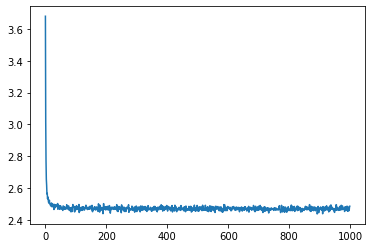

In [95]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

**GRU**

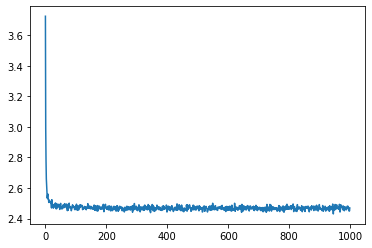

In [96]:
plt.figure()
plt.plot(all_losses2)

**LSTM**

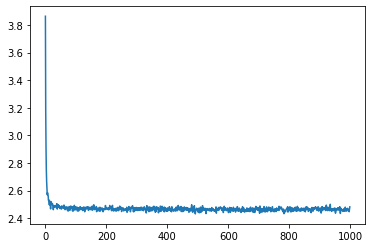

In [97]:
plt.figure()
plt.plot(all_losses3)

## Try different temperatures

Changing the distribution sharpness has an impact on character sampling:

more or less probable things are sampled

**RNN**

In [98]:
print(generate(model,'T', 200, temperature=1))
print("----")
print(generate(model,'Th', 200, temperature=0.8))
print("----")

print(generate(model,'Th', 200, temperature=0.5))
print("----")

print(generate(model,'Th', 200, temperature=0.3))
print("----")

print(generate(model,'Th', 200, temperature=0.1))

C:\Users\William\Anaconda3\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


THES:
DUCHon ng.
D:
D y
Chy, by w Gr.
otho; at ourilard
AMI cow my, ar ashy, INofitin;
Daigr wh othe ck t il akllanerire s, k y mair
LARO:
Thinie, sea p,
Ans cr tsoot'sthithe the pud.
VI ak'?


GBu oun
----
Thon whem, methe:
O:
Ashe wh ckers, belemy he othoites

CANIOROFr d tunougir t,
Seathithen; me ad
IUSTheathashe s thimatose wanomewaif al th be hes wome u I houthal kis,
BUCAne,
To hea tirpust d waf vom
----
Thind w het s y gouth s thishare hend wis then wesen s car ouris ake f thit igre anthe t he me we wisee my m the ane he chen hale IZARO:
The ithean ha be se har t the s morr an there whe whe be the mise
----
The the thes he the histhe the the the be mathin the s ane ll hen he anger he he the be hit ss w an he the he we wis athathe the han he ang cor he the he the s t he here sthe he win wathand the areanore
----
The he the he the the t the the the the an he the the he he the the the he the the the he he the he he the he the he the the the the the the the the the the the he he th

**GRU**

In [99]:
print(generate(model2,'T', 200, temperature=1))
print("----")
print(generate(model2,'Th', 200, temperature=0.8))
print("----")

print(generate(model2,'Th', 200, temperature=0.5))
print("----")

print(generate(model2,'Th', 200, temperature=0.3))
print("----")

print(generate(model2,'Th', 200, temperature=0.1))

That trorencr ia ure thamisthe s therir bu, gher,
ser, hy.
I had ANUSwingothathoy r grt t k, hts te hiantas hinse.
LEN m, llest mere hanf anofinofor PUCETh, ws serssure Dof og! ll, be he achise he thee
----
Thak ke Fo my ten ond s,
SSe, ane sped sour d ucath thest hakelld Hound alo fthe, y he hast trou nderorcowan Bul nk me as thaticouthat tine lyers fo bicht at bave tiliswoour gr he s,
Harth thaithoobr me
----
Th t t the the at ther he thour mour s s sth wie t my me olome mou the yotad le t sare d t the me t te sthow are s t t thar the s w s an the thee s st m be acl he be mord lo beathe the I the se t are ll
----
The he outhathe our the than s the thare s s the win anore s t th the y atour thes ar me t the me boure or me the t that the t t tho here me s the whar t me the s y t thathe s he t se s the the me s s a
----
The the the the the the the the the the the the the the the the the t the the the the the the the the the the the the the the the the the the the the the the the the the

**LSTM**

In [100]:
print(generate(model3,'T', 200, temperature=1))
print("----")
print(generate(model3,'Th', 200, temperature=0.8))
print("----")

print(generate(model3,'Th', 200, temperature=0.5))
print("----")

print(generate(model3,'Th', 200, temperature=0.3))
print("----")

print(generate(model3,'Th', 200, temperature=0.1))

Teasore r g ke-lowrrandser lldueer s y IUS:
MERIs lor hiver tou dofatheade.
Fis so bre atholamis aronsheres, a p owivit th

FI g, t.
Ther artoveavoklashandong st math hthad r ts t,---
Wanitred thathath
----
Th astal ayouks, athe toust t he we as bl aw, d mes, iser tstator s m ir y maly,-be ithig y thoncall rssow br wais f y bll nere teathe istuthuemume ithathod u ined inere fou y wom ouly ncee ans y; d tho
----
The wo d n ther an aran is t y as we d than and I thou at thashe s nd llll s f p y l s pour tor ithe
Wat thasther t as s tous ad fand akerr t the as s st t hithe by le, the shinoure y ar he athe s ben t
----
The arere and s wis way thand th ce the and athe the the the fe t it the the the s the an thare the the whe theathe the be my s the he thare the are se the thather at he t the than the t whe thathe t th
----
The the the the the the the athe the the the the the the t the the the the the the the the the t the the the the athe and the the the the than the the the the the the th

### Improving this code:

(a) Tinker with parameters:

- Is it really necessary to have 100 dims character embeddings
- Chunk length can be gradually increased
- Try changing RNN cell type (GRUs - LSTMs)

(b) Add GPU support to go faster


## ------ End of practical

#### Legacy loading code

In [186]:
import glob
from os.path import split as pathsplit

# dir_train = "dataset/aclImdb/train/"
# dir_test = "dataset/aclImdb/test/"

train_files = glob.glob(dir_train+'pos/*.txt') + glob.glob(dir_train+'neg/*.txt')
test_files = glob.glob(dir_test+'pos/*.txt') + glob.glob(dir_test+'neg/*.txt')

def get_polarity(f):
    """
    Extracts polarity from filename:
    0 is negative (< 5)
    1 is positive (> 5)
    """
    _,name = pathsplit(f)
    if int(name.split('_')[1].split('.')[0]) < 5:
        return 0
    else:
        return 1


def open_one(f):
    
    polarity = get_polarity(f)
    
    with open(f,"r", encoding="utf8") as review:
        text = " ".join(review.readlines()).strip()
    
    return (text,polarity)

print(open_one(train_files[0]))

train = [open_one(x) for x in train_files] #contains (text,pol) couples
test = [open_one(x) for x in test_files]   #contains (text,pol) couples


('Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!', 1)
